In [1]:
import xarray as xr
import glob
import matplotlib.pyplot as plt
import geopandas as gpd
import numpy as np
import pandas as pd

from matplotlib.patches import Rectangle
from scipy.stats import pearsonr

In [2]:
#Select study domain
lat_min, lat_max = 5.0, 5.5
lon_min, lon_max = -5.6, -4.5

In [3]:
validation_dataset = xr.open_dataset('O:\\Man\\Public\\sharing-4270-CERM\\MATNEW\\Era5-Land\\Hourly_Data\\Precipitation\\era5_land_1950_2024_tp_daily_update_DK_regridCLIMEX.nc')
validation_dataset = validation_dataset.rename({"tp": "pr"})
validation_dataset = validation_dataset *1000
validation_dataset = validation_dataset.sel(rlat=slice(lat_min, lat_max), rlon=slice(lon_min, lon_max))

In [4]:
all_pr_model_files = glob.glob("O:\\Man\\Public\\sharing-4270-CERM\\VLYMI\\Climex DK Domain\\pr_daily_bc_V2\\**\\*.nc")

In [5]:
all_pr_model_files

['O:\\Man\\Public\\sharing-4270-CERM\\VLYMI\\Climex DK Domain\\pr_daily_bc_V2\\kct\\pr_EUR-11_CCCma-CanESM2_historical_r5-r6i1p1_OURANOS-CRCM5_kct_day_1951-2100_BC_Esbjerg.nc',
 'O:\\Man\\Public\\sharing-4270-CERM\\VLYMI\\Climex DK Domain\\pr_daily_bc_V2\\kbf\\pr_EUR-11_CCCma-CanESM2_historical_r1-r6i1p1_OURANOS-CRCM5_kbf_day_1951-2100_BC_Esbjerg.nc',
 'O:\\Man\\Public\\sharing-4270-CERM\\VLYMI\\Climex DK Domain\\pr_daily_bc_V2\\kcs\\pr_EUR-11_CCCma-CanESM2_historical_r5-r5i1p1_OURANOS-CRCM5_kcs_day_1951-2100_BC_Esbjerg.nc',
 'O:\\Man\\Public\\sharing-4270-CERM\\VLYMI\\Climex DK Domain\\pr_daily_bc_V2\\kcu\\pr_EUR-11_CCCma-CanESM2_historical_r5-r7i1p1_OURANOS-CRCM5_kcu_day_1951-2100_BC_Esbjerg.nc',
 'O:\\Man\\Public\\sharing-4270-CERM\\VLYMI\\Climex DK Domain\\pr_daily_bc_V2\\kcj\\pr_EUR-11_CCCma-CanESM2_historical_r4-r6i1p1_OURANOS-CRCM5_kcj_day_1951-2100_BC_Esbjerg.nc',
 'O:\\Man\\Public\\sharing-4270-CERM\\VLYMI\\Climex DK Domain\\pr_daily_bc_V2\\kby\\pr_EUR-11_CCCma-CanESM2_histori

In [6]:
# Open multiple files and concatenate along 'time' dimension
validation_ds = validation_dataset

# Select data from 2011 to 2024 
validation_ds_selected = validation_ds.sel(
time=(
    (validation_ds["time"].dt.year >= 2011) &  
    (validation_ds["time"].dt.year <= 2024)  
),
drop=True  # Remove any missing data in the time range
)

val_annual_precipitation_sum = validation_ds_selected.resample(time="YE").mean()
val_annual_precipitation_mean = val_annual_precipitation_sum.mean(dim="time")
val_annual_precipitation_spatial_mean = val_annual_precipitation_mean.mean(dim=["rlat", "rlon"])

val_monthly_precipitation_sum = validation_ds_selected.resample(time="ME").mean()
val_monthly_precipitation_spatial_mean = val_monthly_precipitation_sum.groupby("time.month").mean(dim="time").mean(dim=["rlat", "rlon"])
    

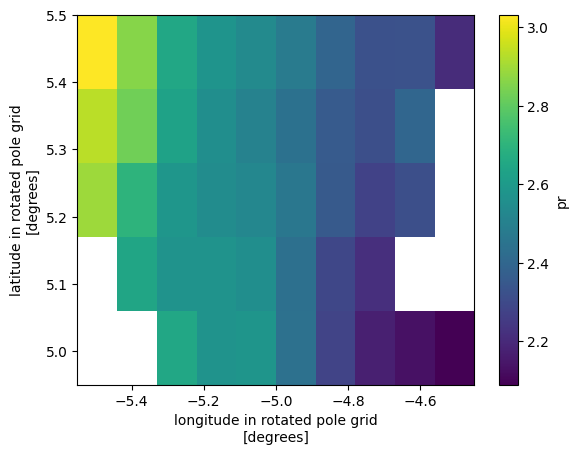

In [7]:
val_annual_precipitation_mean.pr.plot()

In [8]:
model_outputs = {}

In [9]:
%%time

# Open multiple files and concatenate along 'time' dimension
pr_ds = xr.open_mfdataset(all_pr_model_files, combine="nested", concat_dim="realization")
print("Finished opening CLIMEX dataset.")

pr_ds = pr_ds.sel(rlat=slice(lat_min, lat_max), rlon=slice(lon_min, lon_max))

# Select data 
pr_ds = pr_ds.sel(
time=(
    (pr_ds["time"].dt.year >= 2011) &  
    (pr_ds["time"].dt.year <= 2024)  
),
drop=True  # Remove any missing data in the time range
)

#Indicator I
model_annual_precipitation_sum = pr_ds.resample(time="YE").mean()
model_annual_precipitation_mean = model_annual_precipitation_sum.mean(dim="time").mean(dim='realization')
model_annual_precipitation_spatial_mean = model_annual_precipitation_mean.mean(dim=["rlat", "rlon"])
model_annual_rel_difference = ((model_annual_precipitation_spatial_mean - val_annual_precipitation_spatial_mean)/val_annual_precipitation_spatial_mean).pr.values.item()*100

#Indicator II
model_monthly_precipitation_sum = pr_ds.resample(time="ME").mean().mean(dim='realization')
model_monthly_precipitation_spatial_mean = model_monthly_precipitation_sum.groupby("time.month").mean(dim="time").mean(dim=["rlat", "rlon"])
model_monthly_difference = 100 - np.abs((((np.abs(model_monthly_precipitation_spatial_mean - val_monthly_precipitation_spatial_mean).sum()/12)-val_annual_precipitation_spatial_mean)/val_annual_precipitation_spatial_mean).pr.values.item()*100)

#Indicator III
#Calculate standard deviation ratio of monthly values
s_model = model_monthly_precipitation_spatial_mean.std()
s_val = val_monthly_precipitation_spatial_mean.std()
s = s_val / s_model
s = s.pr.values

#Calculate correlation of monthly values
r, _= pearsonr(model_monthly_precipitation_spatial_mean.pr.values.flatten(), 
               val_monthly_precipitation_spatial_mean.pr.values.flatten())

#Calculate KGE (Indicator III)
KGE = 1-((r-1)**2 + (s-1)**2)

mask = ~np.isnan(model_annual_precipitation_mean.pr.values.flatten())

#Indicator IV
correlation, _ = pearsonr(model_annual_precipitation_mean.pr.values.flatten()[mask], 
                          val_annual_precipitation_mean.pr.values.flatten()[mask]) 

# Store the spatial mean in the dictionary
model_outputs = {
    'Indicator I': model_annual_rel_difference,
    'Indicator II': model_monthly_difference,
    'Indicator III' : KGE,
    'Indicator IV' : correlation
}


Finished opening CLIMEX dataset.
CPU times: total: 1min
Wall time: 1min 31s


In [10]:
model_outputs

{'Indicator I': -5.716094002127647,
 'Indicator II': 10.624021291732788,
 'Indicator III': 0.7621292206139663,
 'Indicator IV': 0.9962613476966325}

In [11]:
#Save model_outputs to pandas dataframe
model_outputs_df = pd.DataFrame.from_dict(model_outputs, orient='index')

In [12]:
model_outputs_df

,0
Indicator I,-5.716094
Indicator II,10.624021
Indicator III,0.762129
Indicator IV,0.996261


## Check shapefile projection

In [72]:
shp = gpd.read_file('O:\\Man\\Public\\sharing-4270-CERM\\VLYMI\\CLIMEX\\gadm36_DNK_0.shp')
shp = shp.to_crs("epsg:25832")
shp = shp.to_crs("+proj=ob_tran +o_proj=longlat +o_lon_p =0 +o_lat_p= 39.25 +lon_0 = 18 +to_meter=0.01745329")

In [80]:
var = pr_ds.pr.sel(time = "1989-01-02").mean(dim='realization')

# Get lat/lon
rlon = validation_ds["rlon"]
rlat = validation_ds["rlat"]

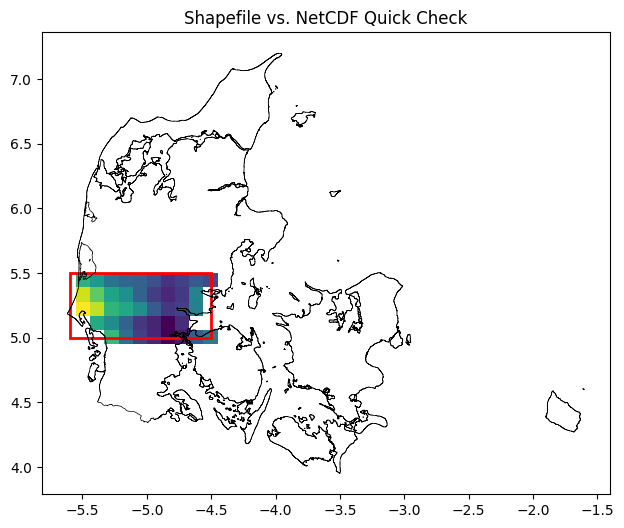

In [81]:
# --- Quick Plot ---
fig, ax = plt.subplots(figsize=(8, 6))

# Plot NetCDF data (without projection)
plt.pcolormesh(rlon, rlat, var.squeeze(), cmap="viridis", shading="auto")

# Overlay Shapefile (without transformation)
shp.boundary.plot(ax=ax, color="black", linewidth=0.5)

# Draw Bounding Box (Red Rectangle)
ax.add_patch(Rectangle((-5.6, 5.0), -4.5 - -5.6, 5.5 - 5.0,
                       linewidth=2, edgecolor='red', facecolor='none'))

# Set title
plt.title("Shapefile vs. NetCDF Quick Check")

plt.show()